In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.USPS(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.USPS(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 6.58M/6.58M [00:00<00:00, 33.1MB/s]


100%|██████████| 1.83M/1.83M [00:00<00:00, 52.9MB/s]


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        if self.fc1 is None:
            num_features = x.size(1)
            self.fc1 = nn.Linear(num_features, 512)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [4]:
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [5]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets_one_hot = torch.zeros(targets.size(0), 10).to(device)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets_one_hot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets_one_hot = torch.zeros(targets.size(0), 10).to(device)
            targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
            outputs = model(inputs)
            loss = criterion(outputs, targets_one_hot)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    accuracy = correct / total
    return running_loss / len(test_loader), accuracy

In [6]:
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/10], Train Loss: 0.0555, Train Accuracy: 0.6760, Test Loss: 0.0431, Test Accuracy: 0.8032
Epoch [2/10], Train Loss: 0.0357, Train Accuracy: 0.8504, Test Loss: 0.0355, Test Accuracy: 0.8391
Epoch [3/10], Train Loss: 0.0300, Train Accuracy: 0.8885, Test Loss: 0.0320, Test Accuracy: 0.8739
Epoch [4/10], Train Loss: 0.0267, Train Accuracy: 0.9121, Test Loss: 0.0318, Test Accuracy: 0.8799
Epoch [5/10], Train Loss: 0.0251, Train Accuracy: 0.9172, Test Loss: 0.0277, Test Accuracy: 0.8874
Epoch [6/10], Train Loss: 0.0235, Train Accuracy: 0.9263, Test Loss: 0.0276, Test Accuracy: 0.9108
Epoch [7/10], Train Loss: 0.0227, Train Accuracy: 0.9328, Test Loss: 0.0258, Test Accuracy: 0.9018
Epoch [8/10], Train Loss: 0.0213, Train Accuracy: 0.9383, Test Loss: 0.0250, Test Accuracy: 0.9083
Epoch [9/10], Train Loss: 0.0212, Train Accuracy: 0.9399, Test Loss: 0.0250, Test Accuracy: 0.9153
Epoch [10/10], Train Loss: 0.0204, Train Accuracy: 0.9423, Test Loss: 0.0236, Test Accuracy: 0.9158


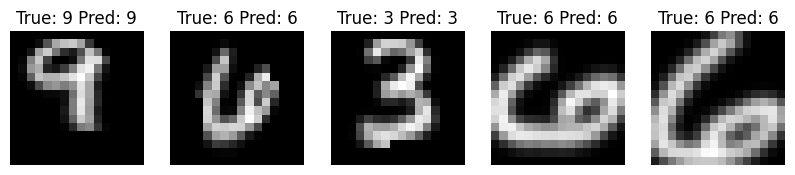

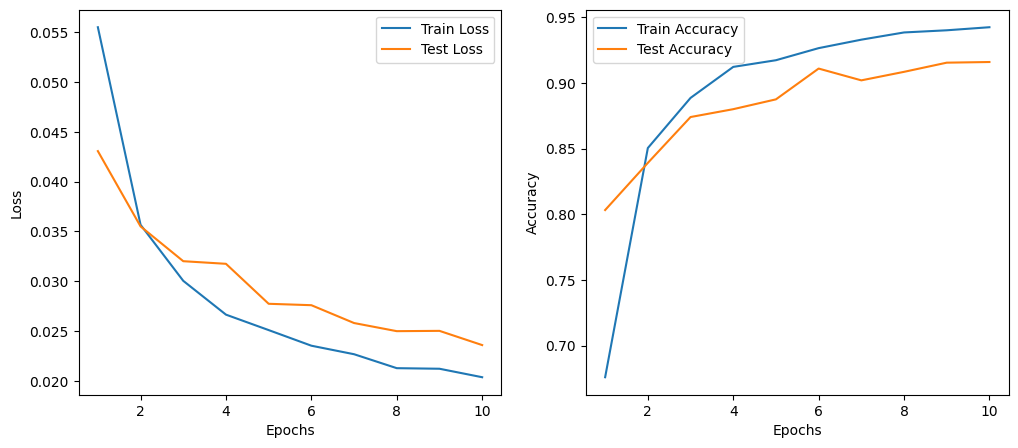

In [7]:
def imshow(model, test_loader, device):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    images = images.cpu().numpy()
    images = np.transpose(images, (0, 2, 3, 1))
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'True: {labels[i].item()} Pred: {predicted[i].item()}')
        ax.axis('off')
    plt.show()

imshow(model, test_loader, device)

epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()